Loading Data

In [1]:
import yfinance as yf

tickers = ["BTC-USD", "^NSEI", "GC=F"]
start_date = "2015-01-01"
end_date = "2024-01-01"

data = yf.download(tickers, start=start_date, end=end_date)
data=data['Close']
print(data.head())

/tmp/ipython-input-2164755985.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed

Ticker         BTC-USD         GC=F        ^NSEI
Date                                            
2015-01-01  314.248993          NaN          NaN
2015-01-02  315.032013  1186.000000  8395.450195
2015-01-03  281.082001          NaN          NaN
2015-01-04  264.195007          NaN          NaN
2015-01-05  274.473999  1203.900024  8378.400391


Data preprocessing

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

tickers = ["BTC-USD", "^NSEI", "GC=F"]
start_date = "2015-01-01"
end_date = "2024-01-01"

data = yf.download(tickers, start=start_date, end=end_date)
data = data['Close']

all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
aligned_data = data.reindex(all_dates)
aligned_data = aligned_data.ffill().bfill()

asset_dfs = {}

for ticker in data.columns:
    df = pd.DataFrame(index=aligned_data.index)
    price_col = aligned_data[ticker]
    log_prices = np.log(price_col)

    df['Price'] = price_col
    df['Log_Return_1d'] = log_prices.diff(1)
    df['Log_Return_5d'] = log_prices.diff(5)
    df['Volatility_20d'] = df['Log_Return_1d'].rolling(window=20).std()
    df['RSI'] = calculate_rsi(price_col)

    asset_dfs[ticker] = df

clean_index = asset_dfs[data.columns[0]].dropna().index
for ticker in data.columns:
    asset_dfs[ticker] = asset_dfs[ticker].loc[clean_index]

cash_df = pd.DataFrame(index=aligned_data.index)
cash_df['Price'] = 1.0
cash_df['Log_Return_1d'] = 0.0
cash_df['Log_Return_5d'] = 0.0
cash_df['Volatility_20d'] = 0.0
cash_df['RSI'] = 0.0
asset_dfs['CASH'] = cash_df



/tmp/ipython-input-1026540279.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed


Kalman filter

In [3]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.8/251.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 7.3 MB/s eta 0:00:00


In [4]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd

transition_matrix = [
    [1, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
]

observation_matrix = [
    [1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
]

trans_cov = np.eye(6) * 0.001
obs_cov = np.eye(5) * 1.0

commodities = ["BTC-USD", "^NSEI", "GC=F"]

for ticker in commodities:
    df = asset_dfs[ticker]

    obs_data = df[['Price', 'Log_Return_1d', 'Log_Return_5d', 'Volatility_20d', 'RSI']].copy()
    obs_data['Price'] = np.log(obs_data['Price'])
    observations = obs_data.values

    initial_state_mean = [
        observations[0, 0],
        0,
        observations[0, 1],
        observations[0, 2],
        observations[0, 3],
        observations[0, 4]
    ]

    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=np.eye(6),
        transition_covariance=trans_cov,
        observation_covariance=obs_cov
    )

    state_means, _ = kf.filter(observations)

    df['Kalman_Level'] = state_means[:, 0]
    df['Kalman_Velocity'] = state_means[:, 1]
    df['Kalman_Ret1'] = state_means[:, 2]
    df['Kalman_Ret5'] = state_means[:, 3]
    df['Kalman_Vol'] = state_means[:, 4]
    df['Kalman_RSI'] = state_means[:, 5]

    log_prices = np.log(df['Price'].values)
    df['Kalman_Error'] = log_prices - df['Kalman_Level']

    asset_dfs[ticker] = df

cash_df = asset_dfs['CASH']
features_to_zero = ['Kalman_Level', 'Kalman_Velocity', 'Kalman_Ret1', 'Kalman_Ret5', 'Kalman_Vol', 'Kalman_RSI', 'Kalman_Error']
for feat in features_to_zero:
    cash_df[feat] = 0.0

if len(cash_df) != len(asset_dfs[commodities[0]]):
    clean_index = asset_dfs[commodities[0]].index
    cash_df = cash_df.loc[clean_index]

asset_dfs['CASH'] = cash_df

Train test split

In [5]:
train_asset_dfs = {}
test_asset_dfs = {}
cutoff_date = "2023-01-01"

for ticker, df in asset_dfs.items():
    train_asset_dfs[ticker] = df.loc[df.index < cutoff_date].copy()
    test_asset_dfs[ticker] = df.loc[df.index >= cutoff_date].copy()

print(f"Training Data End Date: {train_asset_dfs['BTC-USD'].index[-1]}")
print(f"Testing Data Start Date: {test_asset_dfs['BTC-USD'].index[0]}")

Training Data End Date: 2022-12-31 00:00:00
Testing Data Start Date: 2023-01-01 00:00:00


Environment creation

In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class CryptoPortfolioEnv(gym.Env):
    def __init__(self, asset_dfs, lookback_window=20, risk_aversion=0.1):
        super(CryptoPortfolioEnv, self).__init__()

        self.tickers = ["BTC-USD", "^NSEI", "GC=F", "CASH"]
        self.dfs = [asset_dfs[t] for t in self.tickers]
        self.n_assets = len(self.tickers)

        feature_cols = ['Kalman_Velocity', 'Kalman_Error', 'Kalman_Vol',
                        'Kalman_RSI', 'Kalman_Ret1', 'Kalman_Ret5']
        self.asset_data = [df[feature_cols].values for df in self.dfs]
        self.return_data = [df['Log_Return_1d'].values for df in self.dfs]

        self.n_features = len(feature_cols) + 1
        self.n_timesteps = len(self.dfs[0])

        self.lookback_window = lookback_window
        self.risk_aversion = risk_aversion
        self.transaction_cost_pct = 0.001

        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

        obs_size = self.n_assets * self.n_features
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

        self.current_step = 0
        self.current_weights = np.array([0.0, 0.0, 0.0, 1.0])
        self.portfolio_returns_history = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = self.lookback_window
        self.current_weights = np.array([0.0, 0.0, 0.0, 1.0])
        self.portfolio_returns_history = [0.0] * self.lookback_window

        return self._get_observation(), {}

    def step(self, action):
        normalized_weights = np.exp(action) / np.sum(np.exp(action))

        current_step_returns = np.array([ret[self.current_step] for ret in self.return_data])
        portfolio_return = np.sum(normalized_weights * current_step_returns)

        weight_change = np.sum(np.abs(normalized_weights - self.current_weights))
        transaction_cost = weight_change * self.transaction_cost_pct

        self.portfolio_returns_history.append(portfolio_return)
        if len(self.portfolio_returns_history) > self.lookback_window:
            self.portfolio_returns_history.pop(0)

        realized_volatility = np.std(self.portfolio_returns_history)

        reward = (portfolio_return * 100) - (transaction_cost * 100) - (self.risk_aversion * realized_volatility * 100)

        self.current_weights = normalized_weights
        self.current_step += 1

        done = self.current_step >= self.n_timesteps - 1
        truncated = False

        return self._get_observation(), reward, done, truncated, {}

    def _get_observation(self):
        obs = []
        for i in range(self.n_assets):
            asset_features = self.asset_data[i][self.current_step].tolist()
            asset_features.append(self.current_weights[i])
            obs.extend(asset_features)
        return np.array(obs, dtype=np.float32)

Training actor critic model

In [7]:
!pip install stable-baselines3 shimmy>=0.2.1

In [8]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

env = CryptoPortfolioEnv(train_asset_dfs)
vec_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.)

policy_kwargs = dict(net_arch=dict(pi=[128, 128], vf=[128, 128]))

model = PPO("MlpPolicy", vec_env, policy_kwargs=policy_kwargs, verbose=1, learning_rate=0.0003)

model.learn(total_timesteps=10000)

model.save("ppo_crypto_agent")
vec_env.save("vec_normalize.pkl")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cuda device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetim

-----------------------------
| time/              |      |
|    fps             | 550  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 474         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012496904 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.69       |
|    explained_variance   | -0.0777     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.138       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.018      |
|    std                  | 1           |
|    value_loss           | 0.426       |
----------------------------------

Backtesting

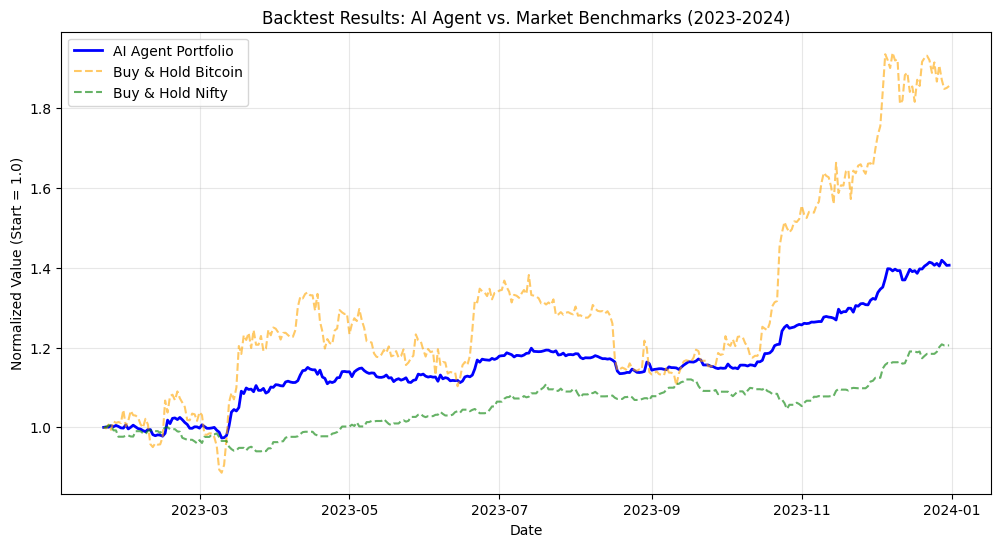

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------
FINAL PERFORMANCE METRICS
------------------------------
Total Return:         40.64%
Annualized Return:    28.29%
Annualized Volatility:10.89%
Sharpe Ratio:         2.3498
Maximum Drawdown:     -5.33%
Avg Daily Turnover:   0.0340
------------------------------
FINAL PORTFOLIO ALLOCATION
------------------------------
BTC-USD   : 0.00%
^NSEI     : 0.00%
GC=F      : 0.00%
CASH      : 100.00%
------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


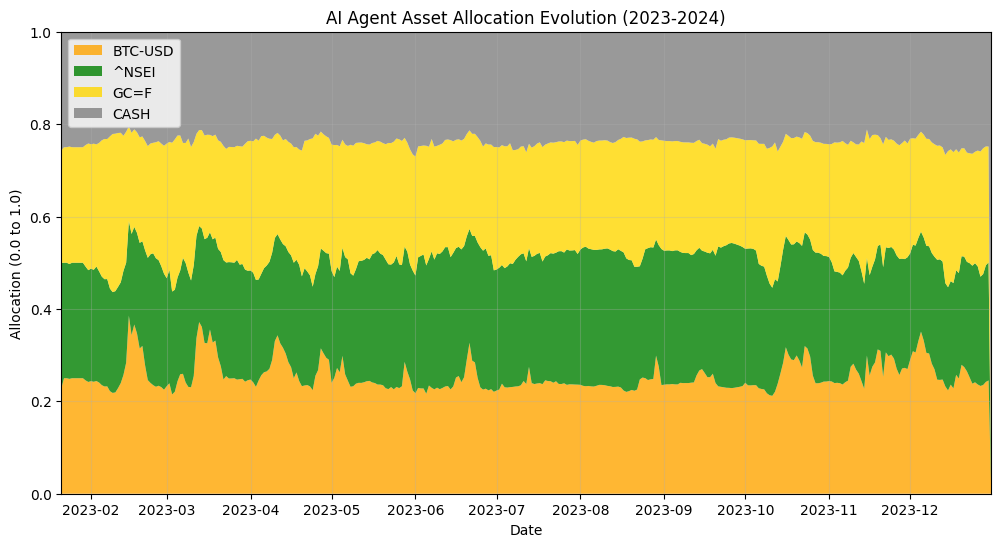

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

env_test = CryptoPortfolioEnv(test_asset_dfs)
vec_env_test = DummyVecEnv([lambda: env_test])

vec_env_test = VecNormalize.load("vec_normalize.pkl", vec_env_test)
vec_env_test.training = False
vec_env_test.norm_reward = False

obs = vec_env_test.reset()
done = False
portfolio_value = 1.0
portfolio_history = [1.0]
weights_history = []

internal_env = vec_env_test.envs[0]
btc_prices = test_asset_dfs['BTC-USD']['Price'].values[internal_env.lookback_window:]
nifty_prices = test_asset_dfs['^NSEI']['Price'].values[internal_env.lookback_window:]

btc_benchmark = btc_prices / btc_prices[0]
nifty_benchmark = nifty_prices / nifty_prices[0]

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env_test.step(action)

    daily_return = internal_env.portfolio_returns_history[-1]
    portfolio_value *= (1 + daily_return)
    portfolio_history.append(portfolio_value)

    raw_weights = vec_env_test.get_attr("current_weights")[0]
    weights_history.append(raw_weights)

portfolio_history = np.array(portfolio_history)
test_dates = test_asset_dfs['BTC-USD'].index[internal_env.lookback_window:]

min_len = min(len(portfolio_history), len(test_dates), len(weights_history), len(btc_benchmark), len(nifty_benchmark))

portfolio_history = portfolio_history[:min_len]
test_dates = test_dates[:min_len]
weights_history = weights_history[:min_len]
btc_benchmark = btc_benchmark[:min_len]
nifty_benchmark = nifty_benchmark[:min_len]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, portfolio_history, label='AI Agent Portfolio', linewidth=2, color='blue')
plt.plot(test_dates, btc_benchmark, label='Buy & Hold Bitcoin', linestyle='--', alpha=0.6, color='orange')
plt.plot(test_dates, nifty_benchmark, label='Buy & Hold Nifty', linestyle='--', alpha=0.6, color='green')

plt.title('Backtest Results: AI Agent vs. Market Benchmarks (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Normalized Value (Start = 1.0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

tickers = ["BTC-USD", "^NSEI", "GC=F", "CASH"]
weights_df = pd.DataFrame(weights_history, columns=tickers)
weights_df.index = test_dates

returns = pd.Series(portfolio_history).pct_change().dropna()
running_max = pd.Series(portfolio_history).cummax()
drawdown = (pd.Series(portfolio_history) - running_max) / running_max

total_return = (portfolio_history[-1] - 1) * 100
annualized_return = ((portfolio_history[-1])**(252/len(portfolio_history)) - 1) * 100
annualized_volatility = returns.std() * np.sqrt(252)
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
max_drawdown = drawdown.min() * 100
daily_turnover = weights_df.diff().abs().sum(axis=1).mean()

print("-" * 30)
print("FINAL PERFORMANCE METRICS")
print("-" * 30)
print(f"Total Return:         {total_return:.2f}%")
print(f"Annualized Return:    {annualized_return:.2f}%")
print(f"Annualized Volatility:{annualized_volatility*100:.2f}%")
print(f"Sharpe Ratio:         {sharpe_ratio:.4f}")
print(f"Maximum Drawdown:     {max_drawdown:.2f}%")
print(f"Avg Daily Turnover:   {daily_turnover:.4f}")
print("-" * 30)

print("FINAL PORTFOLIO ALLOCATION")
print("-" * 30)
final_weights = weights_df.iloc[-1] * 100
for ticker, weight in final_weights.items():
    print(f"{ticker:<10}: {weight:.2f}%")
print("-" * 30)

plt.figure(figsize=(12, 6))
plt.stackplot(weights_df.index,
              weights_df['BTC-USD'],
              weights_df['^NSEI'],
              weights_df['GC=F'],
              weights_df['CASH'],
              labels=tickers,
              colors=['orange', 'green', 'gold', 'grey'],
              alpha=0.8)

plt.title('AI Agent Asset Allocation Evolution (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Allocation (0.0 to 1.0)')
plt.legend(loc='upper left')
plt.margins(0, 0)
plt.grid(True, alpha=0.3)
plt.show()